**<font color = black size=6>实验四：神经网络中的前向传播与后向传播</font>**

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**<font color = blue size=4>第一部分:PyTorch介绍</font>**

这里介绍一小部分PyTorch常用的库和函数，更多需求可参阅[PyTorch官方教程](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)以及[PyTorch官方文档](https://pytorch.org/docs/stable/index.html)。

In [84]:
import torch # 导入的是 torch 而不是 pytorch
print(torch.__version__) # 输出当前pytorch的版本

2.1.0+cpu


1.Tensor

Tensor与NumPy中的ndarray很相似，但Tensor可以利用GPU来加速计算（虽然本门课不用）。

1.1. Tensor的创建

In [85]:
# 创建一个未初始化的Tensor
x = torch.empty(2, 3)
print(x)

# 从一个列表创建Tensor
x = torch.tensor([[1,2,3],[4,5,6]])
print(x)

# 创建一个随机Tensor
x = torch.rand([3, 4])
print(x)

# 创建一个全零Tensor
x = torch.zeros([2, 3])
print(x)

# 创建一个全一Tensor
x = torch.ones([2, 3])
print(x)

tensor([[0., 0., 0.],
        [0., 0., 0.]])
tensor([[1, 2, 3],
        [4, 5, 6]])
tensor([[0.4537, 0.4752, 0.2058, 0.3054],
        [0.9185, 0.4878, 0.0036, 0.1652],
        [0.6361, 0.7840, 0.3336, 0.3593]])
tensor([[0., 0., 0.],
        [0., 0., 0.]])
tensor([[1., 1., 1.],
        [1., 1., 1.]])


1.2. Tensor的运算

In [86]:
# 加减法
x = torch.tensor([[1,2,3],[4,5,6]])
y = torch.tensor([[6,5,4],[3,2,1]])
print(x + y)
print(x - y)

# 对应位置相乘
print(x * y)
print(x.mul(y))

# 矩阵乘法
print(x.matmul(y.T))
print(x @ y.T)

# reshape
print(x.reshape(3, 2))

# 拼接
print(torch.cat([x,y], dim=0)) # 纵向拼接
print(torch.cat([x,y], dim=1)) # 横向拼接

tensor([[7, 7, 7],
        [7, 7, 7]])
tensor([[-5, -3, -1],
        [ 1,  3,  5]])
tensor([[ 6, 10, 12],
        [12, 10,  6]])
tensor([[ 6, 10, 12],
        [12, 10,  6]])
tensor([[28, 10],
        [73, 28]])
tensor([[28, 10],
        [73, 28]])
tensor([[1, 2],
        [3, 4],
        [5, 6]])
tensor([[1, 2, 3],
        [4, 5, 6],
        [6, 5, 4],
        [3, 2, 1]])
tensor([[1, 2, 3, 6, 5, 4],
        [4, 5, 6, 3, 2, 1]])


1.3. Tensor与ndarray的相互转换

In [87]:
x = torch.tensor([[1,2,3],[4,5,6]])
print(x)

# 从Tensor转换到ndarray
y = x.numpy()
print(y)

# Tensor与ndarray是共享空间的
x[:]=0
print(y)

# 从ndarray到Tensor
z = torch.from_numpy(y)
print(z)

tensor([[1, 2, 3],
        [4, 5, 6]])
[[1 2 3]
 [4 5 6]]
[[0 0 0]
 [0 0 0]]
tensor([[0, 0, 0],
        [0, 0, 0]])


2.自动求梯度

In [88]:
a = torch.tensor([[1.,2.]], requires_grad=True) # 把requires_grad设为True, 开始跟踪基于它的所有运算
b = torch.tensor([[3.],[4.]])
c = torch.tensor(5., requires_grad=True)
y = a @ b + c
y.backward() #自动计算梯度
print(a.grad, c.grad) #输出叶子节点a和c的梯度

# 可支持多种运算求梯度，如torch.mean(),torch.sum()等
a = torch.ones(20, requires_grad=True)
z = torch.sum(torch.sigmoid(a))
z.backward()
print(a.grad)

# 多次求梯度时梯度会累加，可使用tensor.grad.zero_()进行手动清零
x = torch.tensor(2., requires_grad=True)
y = x ** 2
y.backward()
print(x.grad)
z = x + 3
z.backward()
print(x.grad)
x.grad.zero_()
print(x.grad)

tensor([[3., 4.]]) tensor(1.)
tensor([0.1966, 0.1966, 0.1966, 0.1966, 0.1966, 0.1966, 0.1966, 0.1966, 0.1966,
        0.1966, 0.1966, 0.1966, 0.1966, 0.1966, 0.1966, 0.1966, 0.1966, 0.1966,
        0.1966, 0.1966])
tensor(4.)
tensor(5.)
tensor(0.)


3. 神经网络（官方教程中的例子）

In [89]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 继承自nn.Module
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 卷积层
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        # nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)
        # 其中in_features表示有多少个输入，out_features表示该层有多少个神经元
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [90]:
# 该神经网络中可学习的参数可以通过net.parameters()访问
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

10
torch.Size([6, 1, 5, 5])


In [91]:
# 随机生成一个输入送入net中，除了第0维是样本个数外，其余维度要与forward()参数中x的维度对应上
input = torch.randn(1, 1, 32, 32) # 1个样本，该样本是有1个通道的32×32的图像
out = net(input) # 进行一次forward()前向传播
print(out)

tensor([[ 0.0279, -0.0320,  0.0505, -0.0042, -0.0875, -0.0619,  0.0767, -0.0196,
          0.0097,  0.0287]], grad_fn=<AddmmBackward0>)


In [92]:
net.zero_grad() # 手动清零神经网络中参数的梯度
out.backward(torch.randn(1, 10)) # 用随机梯度进行一次backward()后向传播来计算梯度

In [93]:
output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
# nn模块提供了许多种类的损失函数，如nn.CrossEntropyLoss()、nn.MSELoss()等等
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(0.3370, grad_fn=<MseLossBackward0>)


计算图如下：
input -> conv2d -> relu -> maxpool2d -> conv2d -> relu -> maxpool2d
      -> flatten -> linear -> relu -> linear -> relu -> linear
      -> MSELoss
      -> loss

In [94]:
# 查看计算图中的函数
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

In [95]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

# 进行一次后向传播
loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
None
conv1.bias.grad after backward
tensor([-0.0041, -0.0018,  0.0104,  0.0061, -0.0167,  0.0003])


In [96]:
# 用梯度下降法(手动)更新net中的参数
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)

In [97]:
# 用PyTorch的优化器来更新net中的参数
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# 在每次循环中应该做的事:
optimizer.zero_grad()   # 把梯度清零
output = net(input) # 进行一次前向传播
loss = criterion(output, target) # 计算误差
loss.backward() # 后向传播
optimizer.step()    # 参数更新

**<font color = blue size=4>第二部分:实验内容</font>**

[Red Wine Quality](https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009)是一个关于红酒品质的数据集，总共有1599个样本，每个样本包含11个(都是连续的)特征以及1个标签，每个标签的取值是连续的。本次实验已经按照8：2的比例划分成了训练数据集'wine_train.csv'以及测试数据集'wine_test.csv'，且每个数据集都已经做了归一化处理。

<span style="color:purple">1) 读入训练数据集'wine_train.csv'与测试数据集'wine_test.csv'。</span>

In [113]:
# -- Your code here --
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
# 读入数据
train_data = pd.read_csv('wine_train.csv')
test_data = pd.read_csv('wine_test.csv')
# 分离特征和标签
X_train = train_data.iloc[:, :-1].values  # 所有行，除了最后一列的数据
y_train = train_data.iloc[:, -1].values  # 所有行，只有最后一列的数据

X_test = test_data.iloc[:, :-1].values
y_test = test_data.iloc[:, -1].values
print(y_train)
print(y_test)
print(len(y_train))
print(len(y_test))

[0.4 0.6 0.8 ... 0.6 0.4 0.4]
[0.6 0.2 0.6 0.4 0.6 0.4 0.8 0.4 0.8 0.6 0.4 0.6 0.4 0.6 0.6 0.8 0.4 0.4
 0.4 0.6 0.6 0.  0.4 0.8 0.6 0.6 0.8 0.6 0.4 0.6 0.4 0.4 0.4 0.8 0.4 0.8
 0.6 0.6 0.6 0.4 0.4 0.2 0.6 0.4 0.6 0.4 0.4 0.6 0.8 0.6 0.8 0.6 0.6 0.4
 0.6 0.8 0.4 0.4 0.6 0.8 0.6 0.6 1.  0.4 0.4 0.4 0.6 0.6 0.6 0.4 0.4 0.6
 0.4 0.4 0.8 0.4 0.6 0.4 0.6 0.8 0.4 0.8 0.6 0.4 0.6 0.4 0.4 0.4 0.6 0.4
 0.6 0.4 0.4 0.6 0.6 0.4 0.4 0.6 0.4 0.6 0.6 0.6 0.6 0.6 0.4 0.4 0.6 0.6
 0.4 0.2 0.6 0.8 0.6 0.4 0.6 0.6 0.8 0.6 0.6 0.8 0.6 0.4 0.4 0.2 0.4 0.8
 0.6 0.4 0.6 0.4 0.6 0.6 0.6 0.8 1.  0.4 0.4 0.4 0.4 0.8 0.4 0.4 0.6 0.4
 0.6 0.4 0.2 0.4 0.6 0.4 0.4 0.4 0.6 0.6 0.6 0.4 0.4 0.8 0.6 0.4 0.4 0.4
 0.8 0.6 0.8 0.4 0.4 0.8 0.8 0.6 0.4 0.4 0.4 0.6 0.8 0.8 0.4 0.4 0.4 0.6
 0.8 0.4 0.6 0.8 0.4 0.8 0.6 0.4 0.4 0.4 0.8 0.6 0.8 0.8 0.6 0.4 0.6 0.4
 0.6 0.4 0.6 0.4 0.6 0.4 0.8 0.4 0.8 0.4 0.6 0.6 0.4 0.6 0.8 0.6 0.4 0.4
 0.4 0.4 0.6 0.6 0.4 0.6 0.4 0.6 0.8 0.8 0.4 0.6 0.4 0.8 0.6 0.4 0.4 0.4
 0.4 0.4 0.4 0.6 0.6 

<span style="color:purple">2) 利用线性层和激活函数搭建一个神经网络，要求输入和输出维度与数据集维度一致，而神经网络深度、隐藏层大小、激活函数种类等超参数自行调整。</span>

In [114]:
# -- Your code here --
# 定义网络结构
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(11, 12)  # 输入层到隐藏层1
        self.fc2 = nn.Linear(12, 12)#隐藏层1到隐藏层2
        self.fc3 = nn.Linear(12, 1)   # 隐藏层2到输出层

    def forward(self, x):
        x = F.relu(self.fc1(x))  # 激活函数为ReLU
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
# 转换数据为torch张量
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  
# 调整形状以匹配输出（只有一个标签值）
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

<span style="color:purple">3) 用梯度下降法进行模型参数更新，记下每轮迭代中的训练损失和测试损失。</span>

In [115]:
# -- Your code here --
# 损失函数和优化器
criterion = nn.MSELoss()  # 均方误差
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)  # 随机梯度下降

# 记录损失
train_losses = []
test_losses = []

# 训练过程
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()   # 清除旧的梯度
    outputs = net(X_train_torch)  # 前向传播
    loss = criterion(outputs, y_train_torch)  # 计算损失
    loss.backward()  # 反向传播
    optimizer.step()  # 更新权重
    train_losses.append(loss.item())# 记录训练损失

    # 测试损失
    with torch.no_grad():  # 确保不会计算梯度
        outputs_test = net(X_test_torch)
        loss_test = criterion(outputs_test, y_test_torch)
        test_losses.append(loss_test.item())

    print(f'Epoch {epoch+1}/{epochs}, Training Loss: {loss.item()}, Test Loss: {loss_test.item()}')

Epoch 1/100, Training Loss: 0.25737208127975464, Test Loss: 0.2474537342786789
Epoch 2/100, Training Loss: 0.24325941503047943, Test Loss: 0.2338804006576538
Epoch 3/100, Training Loss: 0.22998593747615814, Test Loss: 0.2211264669895172
Epoch 4/100, Training Loss: 0.2174992561340332, Test Loss: 0.20913347601890564
Epoch 5/100, Training Loss: 0.205754354596138, Test Loss: 0.19785836338996887
Epoch 6/100, Training Loss: 0.19470998644828796, Test Loss: 0.18725840747356415
Epoch 7/100, Training Loss: 0.18432529270648956, Test Loss: 0.17729365825653076
Epoch 8/100, Training Loss: 0.1745545119047165, Test Loss: 0.1679253876209259
Epoch 9/100, Training Loss: 0.16536477208137512, Test Loss: 0.15912042558193207
Epoch 10/100, Training Loss: 0.1567249745130539, Test Loss: 0.15084345638751984
Epoch 11/100, Training Loss: 0.14860069751739502, Test Loss: 0.14305968582630157
Epoch 12/100, Training Loss: 0.14095672965049744, Test Loss: 0.13573995232582092
Epoch 13/100, Training Loss: 0.133764684200286

<span style="color:purple">4) 画出训练损失和测试损失关于迭代轮数的折线图。</span>

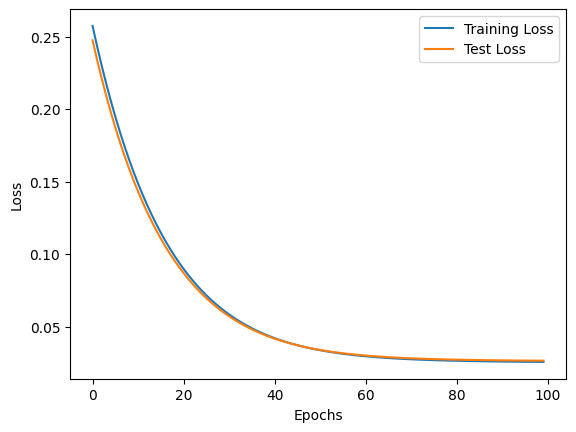

In [116]:
# -- Your code here --
# 绘制损失曲线
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()#显示标签
plt.show()